   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2013-152156  09-11-2013  12-11-2013    Second Class    CG-12520   
1       2  CA-2013-152156  09-11-2013  12-11-2013    Second Class    CG-12520   
2       3  CA-2013-138688  13-06-2013  17-06-2013    Second Class    DV-13045   
3       4  US-2012-108966  11-10-2012  18-10-2012  Standard Class    SO-20335   
4       5  US-2012-108966  11-10-2012  18-10-2012  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   Sout

<ipython-input-16-78b22df6d3fb>:34: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data[col] = pd.to_datetime(data[col] ,errors = 'coerce' ,infer_datetime_format=True )
<ipython-input-16-78b22df6d3fb>:34: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data[col] = pd.to_datetime(data[col] ,errors = 'coerce' ,infer_datetime_format=True )


   Row ID  Order ID  Customer ID    Customer Name        Country  City  \
0       1      2500          143      Claire Gute  United States   194   
1       2      2500          143      Claire Gute  United States   194   
2       3      2296          237  Darrin Van Huff  United States   266   
3       4      4372          705   Sean O'Donnell  United States   153   
4       5      4372          705   Sean O'Donnell  United States   153   

   Postal Code  Product ID  Product Name     Sales  ...  Sub-Category_7  \
0        42420          12           385  261.9600  ...             0.0   
1        42420          55           837  731.9400  ...             0.0   
2        90036         946          1431   14.6200  ...             0.0   
3        33311         319           365  957.5775  ...             0.0   
4        33311        1316           571   22.3680  ...             0.0   

   Sub-Category_8  Sub-Category_9  Sub-Category_10  Sub-Category_11  \
0             0.0             0.0

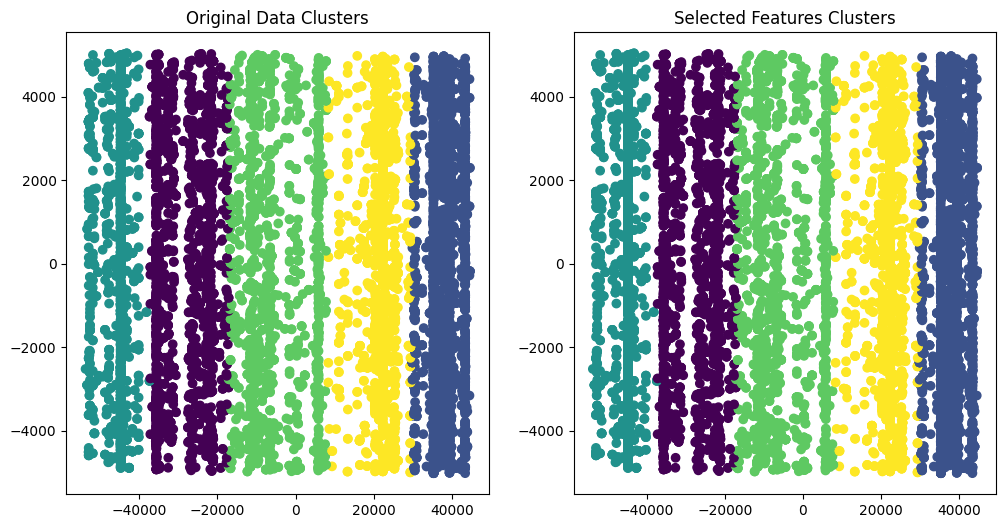

In [16]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning


data = pd.read_csv("Superstore.csv" ,encoding='latin-1')


print(data.head())
print(data.info())
print(data.describe())


categorical_cols = data.select_dtypes(include=['object']).columns
numerical_cols = data.select_dtypes(include=[np.number]).columns

for col in categorical_cols:
    print(f"'{col}' : {data[col].nunique()} ")


le = LabelEncoder()
cols_le = [ 'Order ID' ,'Customer ID' ,'Product ID' ,'City' ,'Product Name']

for col in cols_le:
    data[col] = le.fit_transform(data[col])


date_col = [ 'Order Date' ,'Ship Date' ]
for col in date_col:
    data[col] = pd.to_datetime(data[col] ,errors = 'coerce' ,infer_datetime_format=True )

    data[f"{col}_year"] = le.fit_transform(data[col].dt.year.fillna(0).astype(int))
    data[f"{col}_month"] = le.fit_transform(data[col].dt.month.fillna(0).astype(int))
    data[f"{col}_day"] = le.fit_transform(data[col].dt.day.fillna(0).astype(int))

    data.drop(columns=[col], inplace=True)


print(data.head())
print(data.describe())


cols_onehot = [ 'Ship Mode' ,'Segment' ,'Region' ,'Category' ,'State' ,'Sub-Category' ]
onehot = OneHotEncoder()

'''
encoder = ce.OneHotEncoder(cols=cols_onehot)

data = encoder.fit_transform(data)
'''
for col in cols_onehot:
    encoded_features = onehot.fit_transform(data[col].values.reshape(-1, 1)).toarray()

    onehotd = pd.DataFrame(encoded_features ,columns=[f"{col}_{i}" for i in range(encoded_features.shape[1])])
    data = pd.concat([data, onehotd] ,axis=1)

    data.drop(columns=[col],inplace=True)


print(data.head())
print(data.describe())


z = (data[numerical_cols] - data[numerical_cols].mean()) / data[numerical_cols].std()
z = z.abs()
threshold = 3
mask = z < threshold
cleaned_data = data[mask.all(axis=1)]
removed_outliers = len(data) - len(cleaned_data)
print(f" removed: {removed_outliers}")


print(data.head())
print(data.describe())

def fitness(chromosome, df):

    cols = df.iloc[: , chromosome == 1]
    sums = cols.sum(axis=1)
    return sums.mean()

def Population(size, length):

    return np.random.randint(2 ,size=(size ,length))

def selection(population, fitness_scores):

    selection_probabilities = fitness_scores / np.sum(fitness_scores)

    selected_chromosomes = np.random.choice(len(population) , size=len(population) , p=selection_probabilities )
    return population[selected_chromosomes]

def crossover(parent_a, parent_b, rate=0.8):

    if np.random.rand() < rate:

        crossover_point = np.random.randint(1, len(parent_a) - 1)

        child1 = np.concatenate([parent_a[:crossover_point], parent_b[crossover_point:]])
        child2 = np.concatenate([parent_b[:crossover_point], parent_a[crossover_point:]])
        return child1, child2

    return parent_a, parent_b

def mutate(individual, rate=0.1):

    for gene in range(len(individual)):

        random_value = np.random.rand()

        if random_value < rate:

            individual[gene ] = 1 - individual[gene ]

    return individual


def genetic_algorithm(df, population_size=20, generations=50, crossover_rate=0.8, mutation_rate=0.1):

    chromosome_length = df.shape[1]
    population = Population(population_size ,chromosome_length)

    for generation in range(generations):

        fitness_score = np.array([fitness(chromosome ,df) for chromosome in population])

        selected_population = selection(population, fitness_score)

        new_generation = []

        for i in range(0 ,len(selected_population) ,2):

            parent_a = selected_population[i]
            parent_b = selected_population[(i + 1) % len(selected_population)]

            child1, child2 = crossover(parent_a, parent_b, crossover_rate)

            new_generation.append(mutate(child1, mutation_rate))
            new_generation.append(mutate(child2, mutation_rate))

        population = np.array(new_generation)

        best_fitness = np.max(fitness_score)
        print(f"generation {generation + 1}: best fitness  = {best_fitness}")


        final_fitness_scores = np.array([fitness(chromosome ,df) for chromosome in population])
        best_chromosome = population[np.argmax(final_fitness_scores)]

    return best_chromosome



numerical_data = cleaned_data[numerical_cols]
best_solution = genetic_algorithm(numerical_data)
selected_features = numerical_data.columns[best_solution == 1]
print("Selected Features:", list(selected_features))


from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


def Population_with_kmeans(size, length, df, k=3):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df)
    centroids = (kmeans.cluster_centers_ > 0).astype(int)
    random_population = np.random.randint(2, size=(size - len(centroids), length))

    return np.vstack([random_population , centroids])


def fitness_with_silhouette(chromosome, df, k=3):
    selected_cols = df.iloc[:, chromosome == 1]
    if selected_cols.empty:
        return 0
    kmeans = KMeans(n_clusters=k, random_state=42).fit(selected_cols)
    score = silhouette_score(selected_cols, kmeans.labels_)
    return score


def compare_and_visualize(df, selected_features, k=5):

    selected_features = [col for col in selected_features if col in df.columns]


    selected_features_df = df[selected_features]


    kmeans_original = KMeans(n_clusters=k, random_state=42).fit(df)
    ssd_original = kmeans_original.inertia_

    kmeans_selected = KMeans(n_clusters=k, random_state=42).fit(selected_features_df)
    ssd_selected = kmeans_selected.inertia_

    print(f"Original SSD: {ssd_original}, Selected Features SSD: {ssd_selected}")


    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(df)
    reduced_selected = pca.fit_transform(selected_features_df)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_original.labels_)
    plt.title("Original Data Clusters")

    plt.subplot(1, 2, 2)
    plt.scatter(reduced_selected[:, 0], reduced_selected[:, 1], c=kmeans_selected.labels_)
    plt.title("Selected Features Clusters")
    plt.show()



compare_and_visualize(numerical_data, list(selected_features))
